# A Demo and Comparison of Categorical Methods

**The feature engineering step is arguably the most intensive and manual component of designing and completing a machine learning model from a dataset. Within feature engineering itself, categorical encoding is an essential part of nearly every dataset, but often comes with its own challenges.**

In this notebook, we will be exploring where and when to apply different categorical methods. Specifically, we will be applying a number of categorical methods to a dataset, and then comparing the resulting performance of each of the categorical methods. For a detailed guide on the when/how of using categorical methods, check out [this comprehensive notebook](https://github.com/FeatureLabs/categorical-encoding/blob/master/notebooks/categorical-encoding-guide.ipynb).

Specifically for this demo, we will be using the dataset located at https://www.kaggle.com/c/instacart-market-basket-analysis/data. For the purposes of this demo, we will not be detailing every single step involved in the machine learning process. For that, check out [this comprehensive demo](https://github.com/Featuretools/predict-next-purchase) by Feature Labs, Inc. We will still be outlining several key steps, however.

If you are planning to follow this tutorial yourself, please refer to [this link](https://github.com/Featuretools/predict-next-purchase#running-the-tutorial) for instructions to download/prepare the data. 

In [1]:
import featuretools as ft
import pandas as pd
import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import os
import category_encoders as ce

W0718 17:39:12.248616 4652426688 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


## Load EntitySet

This is the first step in loading data into Featuretools. For now, as the entire dataset contains 1.3 million rows, we will load only one partition of our data, which still contains all the relevant information to the users contained in the partition.

In [2]:
es = utils.load_entityset("partitioned_data/part_1/")
es

Entityset: instacart
  Entities:
    order_products [Rows: 156605, Columns: 7]
    orders [Rows: 16328, Columns: 3]
    users [Rows: 1000, Columns: 2]
  Relationships:
    order_products.order_id -> orders.order_id
    orders.user_id -> users.user_id

## Explanation of Data/Problem

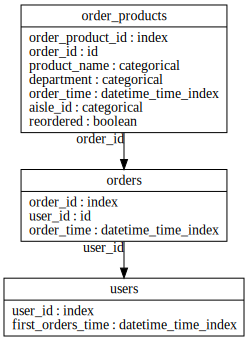

In [3]:
es.plot()

In this dataset, we can see that we're given information about each user, each of their specific orders, and the purchased products themselves. We can see that data columns themselves are not terribly complex, but there are two categoricals that we must account for: `product_name` and `department`.

In the spirit of the Kaggle competition that this originated from, in this notebook, we will predict whether or not a user will purchase a specific product within the next specified time period.

In [4]:
es['order_products'].df['product_name'].describe()

count     156605
unique     15408
top       Banana
freq        2058
Name: product_name, dtype: object

Following our [guide](https://github.com/FeatureLabs/categorical-encoding/blob/master/notebooks/categorical-encoding-guide.ipynb), 15408 unique values is much greater than our suggested <15 cardinality for one-hot encoding, forcing us to possibly consider other methods. 

For the purposes of this notebook, we will predict whether or not a user will purchase a banana in the next 4 weeks.

## Make Labels

For supervised machine learning, we first need to create labels. 

To generate training examples, we can use Featuretools' powerful time handling capabilities. Any user within the `training_window` before `cutoff_time` will be examined to see if they purchase Bananas within the `prediction_window`.

In [5]:
label_times = utils.make_labels(es=es,
                                product_name = "Banana",
                                cutoff_time = pd.Timestamp('March 15, 2015'),
                                prediction_window = ft.Timedelta("4 weeks"),
                                training_window = ft.Timedelta("60 days"))
label_times.head(5)

,user_id,time,label
0,1001,2015-03-15,False
1,1002,2015-03-15,False
2,1003,2015-03-15,False
3,1004,2015-03-15,False
4,1005,2015-03-15,False


## Automated Feature Engineering with Featuretools DFS

In [6]:
feature_matrix, features = ft.dfs(target_entity="users", 
                                  cutoff_time=label_times,
                                  training_window=ft.Timedelta("60 days"), # same as above
                                  entityset=es,
                                  verbose=True)
feature_matrix.head()

Built 76 features
Elapsed: 00:15 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


,COUNT(orders),COUNT(order_products),PERCENT_TRUE(order_products.reordered),NUM_UNIQUE(order_products.product_name),NUM_UNIQUE(order_products.department),NUM_UNIQUE(order_products.aisle_id),MODE(order_products.product_name),MODE(order_products.department),MODE(order_products.aisle_id),DAY(first_orders_time),...,COUNT(order_products WHERE department = pantry),COUNT(order_products WHERE department = snacks),COUNT(order_products WHERE department = canned goods),COUNT(order_products WHERE department = bakery),COUNT(order_products WHERE product_name = Organic Avocado),COUNT(order_products WHERE product_name = Organic Hass Avocado),COUNT(order_products WHERE product_name = Organic Strawberries),COUNT(order_products WHERE product_name = Large Lemon),COUNT(order_products WHERE department = deli),label
user_id,,,,,,,,,,,,,,,,,,,,,
1001,2,33,0.424242,26,11,20,Animal Crackers,snacks,78,1,...,0.0,9.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,False
1002,5,49,0.244898,40,8,16,Chocolate Bars Minis Mix Variety Pack,snacks,45,1,...,9.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1003,6,79,0.670886,41,12,26,Fat Free Milk,dairy eggs,120,1,...,4.0,6.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,False
1004,8,169,0.692308,76,11,19,Organic Granny Smith Apple,produce,83,1,...,2.0,1.0,0.0,7.0,2.0,0.0,5.0,0.0,1.0,False
1005,5,54,0.518519,38,12,28,Blueberry Waffles,dairy eggs,24,1,...,2.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,False


We notice that we still have several columns containing categorical values. Before we can input this matrix into our machine learning algorithm, we must first figure out how to apply categorical encoding to these values.

## Categorical Encoding

We first examine several of the columns to get a sense of the categorical data as well as its cardinality.

In [7]:
feature_matrix['MODE(order_products.product_name)'].describe()

count        782
unique       544
top       Banana
freq          46
Name: MODE(order_products.product_name), dtype: object

In [8]:
feature_matrix['MODE(order_products.department)'].describe()

count         782
unique         17
top       produce
freq          391
Name: MODE(order_products.department), dtype: object

`product_name` still has 544 unique values--better than our initial impression of the dataset, but it means that we still have a dataset with high cardinality.

`department`, however, is much lower in terms of cardinality, suggesting that applying one-hot encoding will not face any issues.

In [9]:
fm_encoded, features_encoded = ft.encode_features(feature_matrix,
                                                  features,
                                                  top_n=544)

print("Number of features %s" % len(features_encoded))
features_encoded[:10]

Number of features 1294


[<Feature: COUNT(orders)>,
 <Feature: COUNT(order_products)>,
 <Feature: PERCENT_TRUE(order_products.reordered)>,
 <Feature: NUM_UNIQUE(order_products.product_name)>,
 <Feature: NUM_UNIQUE(order_products.department)>,
 <Feature: NUM_UNIQUE(order_products.aisle_id)>,
 <Feature: MODE(order_products.product_name) = Banana>,
 <Feature: MODE(order_products.product_name) = Bag of Organic Bananas>,
 <Feature: MODE(order_products.product_name) = Organic Baby Spinach>,
 <Feature: MODE(order_products.product_name) = Michigan Organic Kale>]

In [10]:
fm_encoded.head()

,COUNT(orders),COUNT(order_products),PERCENT_TRUE(order_products.reordered),NUM_UNIQUE(order_products.product_name),NUM_UNIQUE(order_products.department),NUM_UNIQUE(order_products.aisle_id),MODE(order_products.product_name) = Banana,MODE(order_products.product_name) = Bag of Organic Bananas,MODE(order_products.product_name) = Organic Baby Spinach,MODE(order_products.product_name) = Michigan Organic Kale,...,COUNT(order_products WHERE department = pantry),COUNT(order_products WHERE department = snacks),COUNT(order_products WHERE department = canned goods),COUNT(order_products WHERE department = bakery),COUNT(order_products WHERE product_name = Organic Avocado),COUNT(order_products WHERE product_name = Organic Hass Avocado),COUNT(order_products WHERE product_name = Organic Strawberries),COUNT(order_products WHERE product_name = Large Lemon),COUNT(order_products WHERE department = deli),label
user_id,,,,,,,,,,,,,,,,,,,,,
1001,2,33,0.424242,26,11,20,0,0,0,0,...,0.0,9.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,False
1002,5,49,0.244898,40,8,16,0,0,0,0,...,9.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1003,6,79,0.670886,41,12,26,0,0,0,0,...,4.0,6.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,False
1004,8,169,0.692308,76,11,19,0,0,0,0,...,2.0,1.0,0.0,7.0,2.0,0.0,5.0,0.0,1.0,False
1005,5,54,0.518519,38,12,28,0,0,0,0,...,2.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,False


From a quick glance, we can see that one-hot encoding increased the number of columns from 77 to 1295. We only have 782 rows in this partition, but we can see that if we had included all the partitions, this may present a serious memory issue.

## Machine Learning

We will continue with this smaller partition and train a Random Forest Classifier on it. With Featuretools, this becomes very simple.

In [11]:
X = utils.merge_features_labels(fm_encoded, label_times)
X.drop(["user_id", "time"], axis=1, inplace=True)
X = X.fillna(0)
y = X.pop("label")

In [12]:
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf,X=X, y=y, cv=3,
                         scoring="roc_auc", verbose=True)

"AUC %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.0s finished


'AUC 0.82 +/- 0.04'

In [13]:
clf.fit(X, y)
top_features = utils.feature_importances(clf, features_encoded, n=20)

1: Feature: COUNT(order_products WHERE product_name = Banana), 0.090
2: Feature: MODE(order_products.product_name) = Banana, 0.032
3: Feature: MODE(orders.MODE(order_products.product_name)) = Banana, 0.021
4: Feature: MEAN(orders.NUM_UNIQUE(order_products.product_name)), 0.016
5: Feature: STD(orders.PERCENT_TRUE(order_products.reordered)), 0.016
6: Feature: MEAN(orders.COUNT(order_products)), 0.016
7: Feature: MEAN(orders.NUM_UNIQUE(order_products.aisle_id)), 0.015
8: Feature: COUNT(order_products WHERE department = produce), 0.015
9: Feature: COUNT(order_products WHERE department = dairy eggs), 0.015
10: Feature: COUNT(order_products), 0.015
11: Feature: STD(orders.NUM_UNIQUE(order_products.product_name)), 0.014
12: Feature: STD(orders.NUM_UNIQUE(order_products.department)), 0.014
13: Feature: PERCENT_TRUE(order_products.reordered), 0.014
14: Feature: NUM_UNIQUE(order_products.product_name), 0.013
15: Feature: SUM(orders.NUM_UNIQUE(order_products.department)), 0.013
16: Feature: SUM(o

## Alternative One-hot Encoding Approach

First, from examining the top_features, it appears that most of the categories may not actually affect the model performance. Therefore, we could probably afford to only encode several of the features (featuretools defaults to `top_n=10`).

In [14]:
fm_encoded, features_encoded = ft.encode_features(feature_matrix,
                                                  features,)

print("Number of features %s" % len(features_encoded))

Number of features 161


In [15]:
utils.machine_learning_score(fm_encoded, label_times)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s finished


'AUC 0.84 +/- 0.02'

Thus, when we include all of the data, we would no longer face memory issues with fewer encoded categorical values. However, this still gives us a way to incorporate the relevant categorical data, helping with our prediction.

As demonstrated by this example, the decision should be made by considering the results of the machine learning model. If, for some reason, purchasing Apples meant that the user would absolutely never touch a Banana, then we would need to find a way to incorporate that into our encoding. However, our model performs well, and thus we can get away with lower dimensionality.

## Comparing Categorical Encoding Methods

In [22]:
ce_ord = ce.OrdinalEncoder()
fm_encoded = ce_ord.fit_transform(feature_matrix)
utils.machine_learning_score(fm_encoded, label_times)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s finished


'AUC 0.83 +/- 0.03'

In [25]:
ce_one_hot = ce.OneHotEncoder()
fm_encoded = ce_one_hot.fit_transform(feature_matrix)
utils.machine_learning_score(fm_encoded, label_times)

       COUNT(orders)  COUNT(order_products)  \
count     782.000000             782.000000   
mean        4.539642              42.925831   
std         3.503478              39.230755   
min         1.000000               2.000000   
25%         2.000000              17.000000   
50%         3.000000              31.000000   
75%         6.000000              56.000000   
max        54.000000             325.000000   

       PERCENT_TRUE(order_products.reordered)  \
count                              782.000000   
mean                                 0.423398   
std                                  0.213970   
min                                  0.000000   
25%                                  0.263158   
50%                                  0.416667   
75%                                  0.571429   
max                                  1.000000   

       NUM_UNIQUE(order_products.product_name)  \
count                               782.000000   
mean                              

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s finished


'AUC 0.82 +/- 0.03'

In [20]:
ce_bin = ce.BinaryEncoder()
fm_encoded = ce_bin.fit_transform(feature_matrix)
utils.machine_learning_score(fm_encoded, label_times)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


'AUC 0.83 +/- 0.02'

In [21]:
ce_hash = ce.HashingEncoder(n_components=8)
fm_encoded = ce_hash.fit_transform(feature_matrix)
utils.machine_learning_score(fm_encoded, label_times)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


'AUC 0.84 +/- 0.02'